In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geodatasets
import os
import ast
import math

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from data_loading_utils import DataLoader


In [2]:
# load data
path = os.path.join('data', 'nei_pollution')
dl = DataLoader(path)

df = dl.get_dfs()
df['Lat/Lon'] = df['Lat/Lon'].apply(ast.literal_eval)

df.head()

,State,State-County,Pollutant,Emissions (Tons),Pollutant Type,Site Name,EIS Facility ID,Facility Type,Street Address,NAICS,Lat/Lon,EPA Region,FIPS,Lat,Lon
0,Alabama,AL - Autauga,Carbon Dioxide,2.391966e+06,GHG,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
1,Alabama,AL - Autauga,Nitrogen Oxides,2.110000e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
2,Alabama,AL - Autauga,Ammonia,1.097200e+02,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
3,Alabama,AL - Autauga,PM2.5 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287
4,Alabama,AL - Autauga,PM10 Primary (Filt + Cond),9.240000e+01,CAP,Alabama Power Company,10708711,Electricity Generation via Combustion,3305 County Road 26,Fossil Fuel Electric Power Generation,"[-86.738287, 32.650024]",4,01001,32.650024,-86.738287


In [3]:
# keep just columns corresponsing to location
locations_df = df[['EIS Facility ID', 'Site Name', 'State', 'Lat', 'Lon']]
locations_df = locations_df.drop_duplicates()
locations_df.head()

# just keep california because trying to cluster eveything seems to crash jupyter
ca_df = locations_df.loc[locations_df['State'] == 'California', :]
ca_df.head()

,EIS Facility ID,Site Name,State,Lat,Lon
39167,18172311,7-11 STORE,California,37.702889,-121.721006
39173,18175311,7-11 STORE #33163,California,37.718678,-121.910240
39179,18366311,7-ELEVEN,California,37.717347,-121.723735
39185,18172511,7-ELEVEN #32734,California,37.698070,-121.772987
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424


(0.0, 0.1)

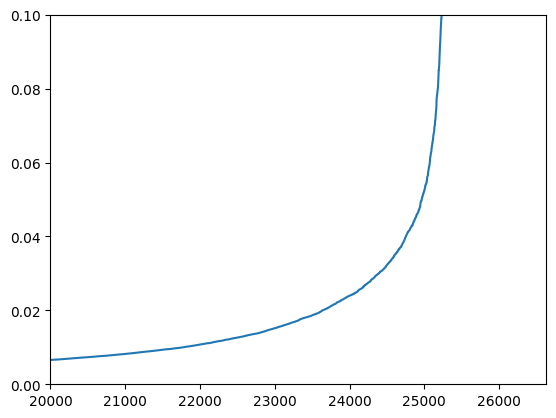

In [4]:
# find nearest neighbbors to tune dbscan
nn = NearestNeighbors(n_neighbors=25)
nn_fit = nn.fit(ca_df[['Lat', 'Lon']])
dist, indices = nn_fit.kneighbors(ca_df[['Lat', 'Lon']])

dist = np.sort(dist, axis=0)
dist = dist[:, 1]
plt.plot(dist)
plt.xlim(20000)
plt.ylim(0, 0.1)

In [5]:
dbscan = DBSCAN(eps=0.03)
ca_df['Cluster'] = dbscan.fit_predict(ca_df[['Lat', 'Lon']])
ca_df['Cluster'] = ca_df['Cluster'].astype(str)
ca_df.head()

/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_12563/2350223037.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['Cluster'] = dbscan.fit_predict(ca_df[['Lat', 'Lon']])
/var/folders/0b/l4__m5492hg2pxtxg6z149mh0000gn/T/ipykernel_12563/2350223037.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_df['Cluster'] = ca_df['Cluster'].astype(str)


,EIS Facility ID,Site Name,State,Lat,Lon,Cluster
39167,18172311,7-11 STORE,California,37.702889,-121.721006,0
39173,18175311,7-11 STORE #33163,California,37.718678,-121.910240,0
39179,18366311,7-ELEVEN,California,37.717347,-121.723735,0
39185,18172511,7-ELEVEN #32734,California,37.698070,-121.772987,0
39191,18521411,7-ELEVEN INC.,California,37.795672,-122.253424,1


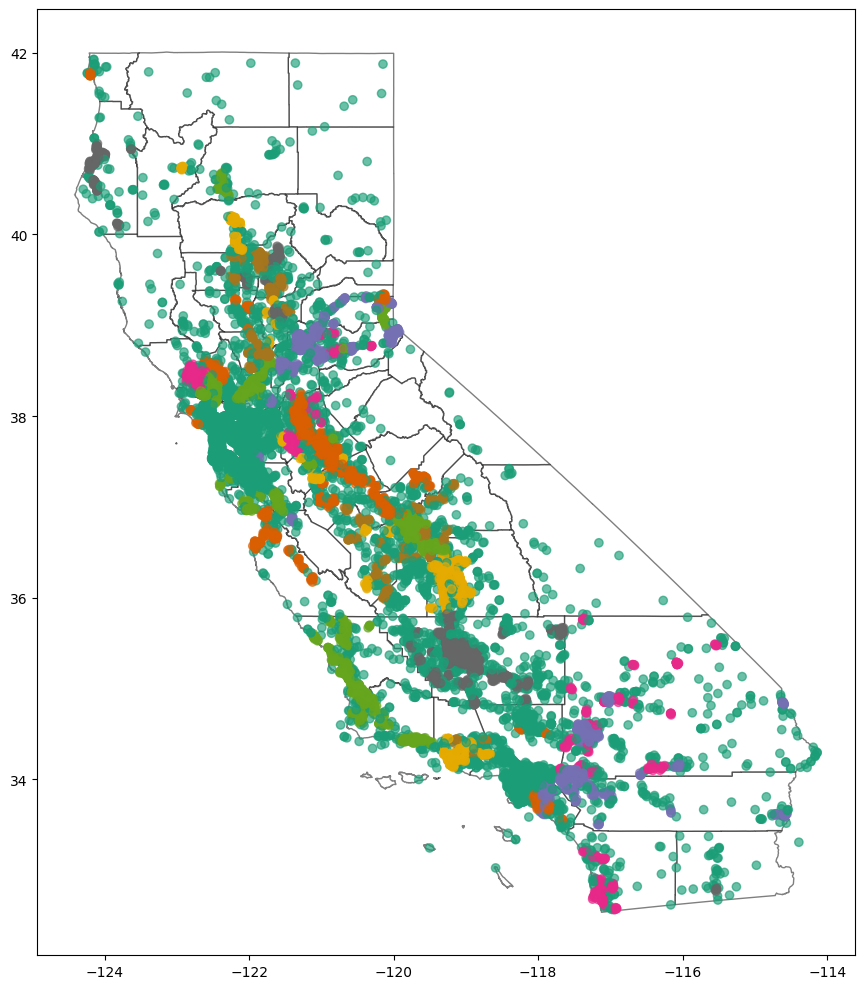

In [6]:
# plot the raw clustering results
gdf = gpd.GeoDataFrame(ca_df, geometry = gpd.points_from_xy(ca_df.Lon, ca_df.Lat), crs="EPSG:4326")

ca_county_lines = 'California_Counties.geojson'

california = gpd.read_file(os.path.join('data', ca_county_lines))
ax = california.plot(figsize=(10,10), alpha=0.5, edgecolor='k', color='white')

legend = False
gdf.plot(kind='geo', column='Cluster', legend=legend, alpha = 0.65, ax=ax, cmap='Dark2')

if legend:
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1, 0.5, 0.1, 0.1))

plt.tight_layout()

### Pollution Sums for each cluster
Visualizing every single point can be visually overwhelming. Let's compare the pollution sums for each cluster and only plot the highest ones.

Is there a sensible threshold at which to filter total emissions for each cluster?

In [7]:
site_sums_df = df[['EIS Facility ID', 'Emissions (Tons)']].groupby('EIS Facility ID', as_index=False).sum()
site_sums_df = locations_df.merge(site_sums_df, on='EIS Facility ID')
ca_sums_df = site_sums_df.merge(ca_df[['EIS Facility ID', 'Cluster']], on='EIS Facility ID')
ca_sums_df.describe()

,EIS Facility ID,Lat,Lon,Emissions (Tons)
count,2.536600e+04,25366.000000,25366.000000,2.536600e+04
mean,1.304782e+07,36.998224,-120.753437,3.543271e+03
std,6.413190e+06,1.622029,1.693073,8.161310e+04
min,1.110000e+02,32.562466,-124.294220,1.500000e-12
25%,1.005119e+07,35.771619,-122.073135,1.717246e-02
50%,1.437416e+07,37.464456,-121.283075,1.219687e-01
75%,1.841509e+07,37.952801,-119.560837,6.722814e-01
max,2.148311e+07,41.927260,-114.139670,6.198461e+06


<Axes: xlabel='Emissions (Tons)', ylabel='Percent'>

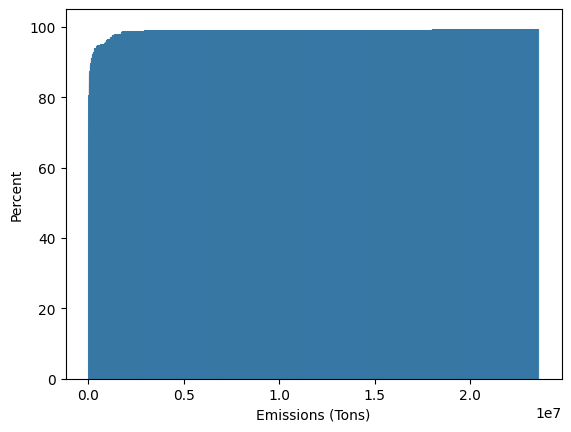

In [8]:
ca_cluster_df = ca_sums_df.loc[:, 'Emissions (Tons)':].groupby('Cluster').sum()
total_emissions = ca_cluster_df['Emissions (Tons)'].sum()
ca_cluster_df['Percent of Total Emissions'] = ca_cluster_df['Emissions (Tons)'] / total_emissions
ca_cluster_df['Emissions (kTons)'] = ca_cluster_df['Emissions (Tons)'] / 1000
cum_percent_total_emissions = np.cumsum(ca_cluster_df['Percent of Total Emissions'].sort_values())
# sns.lineplot(y = cum_percent_total_emissions, x = cum_percent_total_emissions.index)
sns.histplot(ca_cluster_df, x='Emissions (Tons)', cumulative=True, stat='percent')

Find wuantiles for each cluster emissions values. Policy makers love quantiles.

In [9]:
ca_cluster_df.quantile([0.75, 0.8, 0.9, 0.95, 0.99])

,Emissions (Tons),Percent of Total Emissions,Emissions (kTons)
0.75,7.123475e+03,0.000079,7.123475
0.80,1.557023e+04,0.000173,15.570232
0.90,1.240378e+05,0.001380,124.037815
0.95,5.207049e+05,0.005793,520.704870
0.99,2.553903e+06,0.028415,2553.903487


In [10]:
ca_cluster_df.loc[ca_cluster_df['Emissions (Tons)'] > 521, :].sum()

Emissions (Tons)              8.987117e+07
Percent of Total Emissions    9.999173e-01
Emissions (kTons)             8.987117e+04
dtype: float64

In [11]:
# cluster ids of top 10 emissions
top_clusters = ca_cluster_df.sort_values('Percent of Total Emissions', ascending=False).iloc[:10, :].index
top_clusters

Index(['122', '1', '-1', '197', '81', '225', '155', '224', '107', '89'], dtype='object', name='Cluster')

Plot just the top 10 clusters. This shows high density regions in SF Bay Area and Los Angeles as the top pollution clusters. The next highest is -1 (the noise cluster). These sites are more isolated than thos in a cluster, but still seem to be significant polutters given the bubble sizes.

<Axes: xlabel='Emissions (kTons)', ylabel='Cluster'>

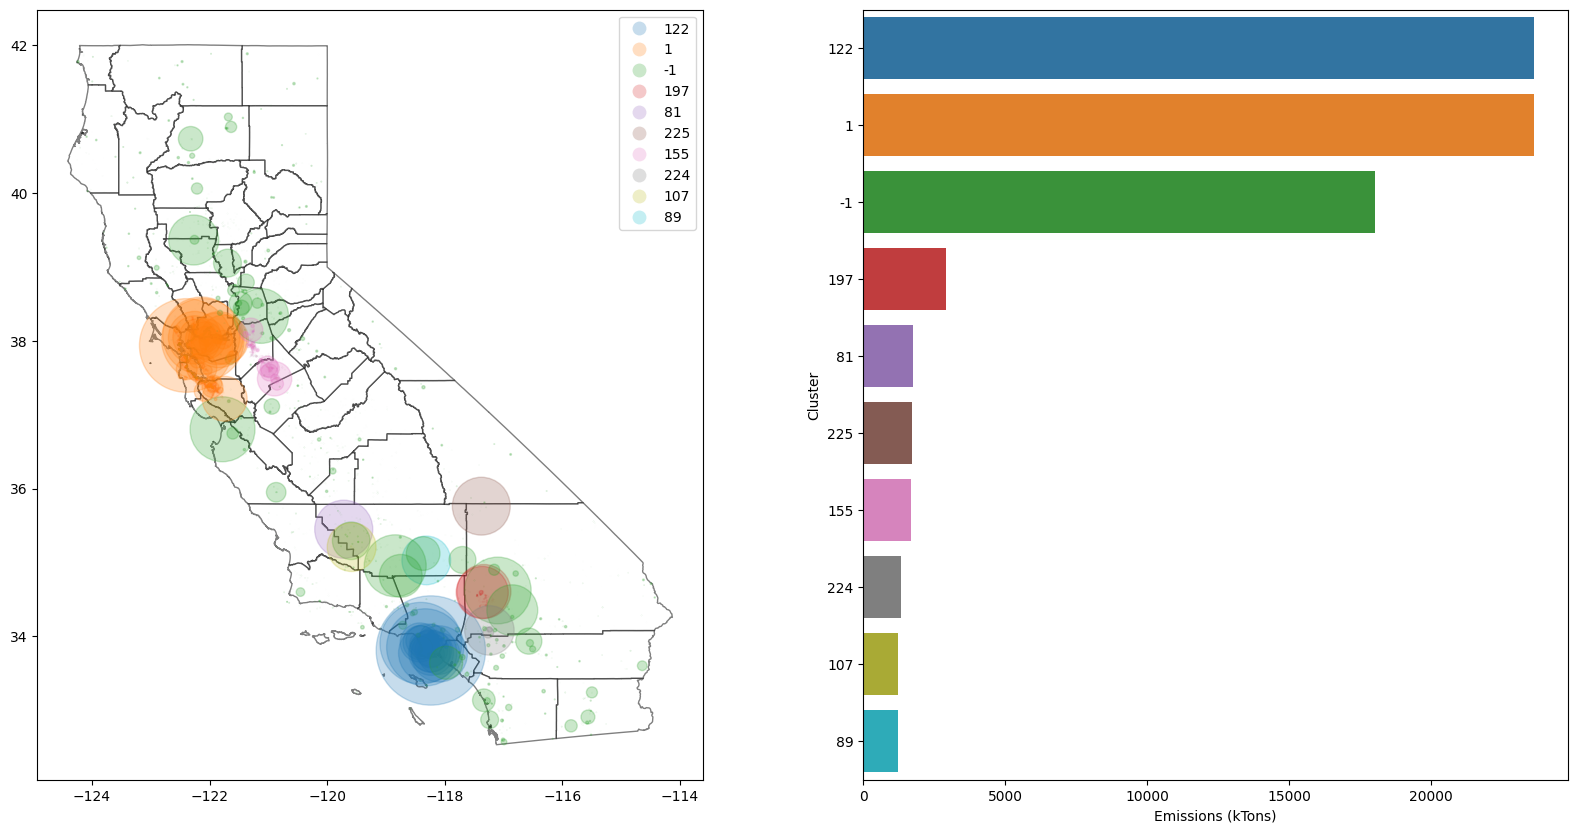

In [12]:
top_clusters_df = ca_df.loc[ca_df.Cluster.isin(top_clusters), :]

cluster_emissions_df = top_clusters_df.merge(site_sums_df[['EIS Facility ID', 'Emissions (Tons)']], on='EIS Facility ID')
cluster_emissions_df = cluster_emissions_df.drop_duplicates(subset = 'EIS Facility ID')
cluster_emissions_df['Emissions (kTons)'] = cluster_emissions_df['Emissions (Tons)'] / 1000

gdf = gpd.GeoDataFrame(cluster_emissions_df, geometry = gpd.points_from_xy(cluster_emissions_df.Lon, cluster_emissions_df.Lat), crs="EPSG:4326")

ca_county_lines = 'California_Counties.geojson'

california = gpd.read_file(os.path.join('data', ca_county_lines))

# values for bar plot to set order of cluster colors
bar_plot_df = cluster_emissions_df.groupby('Cluster', as_index=False).sum().reset_index()
bar_plot_df = bar_plot_df.sort_values('Emissions (kTons)', ascending=False)
cluster_categories = bar_plot_df['Cluster']

fig, axes = plt.subplots(1, 2, figsize=(20,10))

ax_map = axes[0]

california.plot(alpha=0.5, edgecolor='k', color='white', ax = ax_map)

legend = True
gdf.plot(kind='geo', column='Cluster', legend=legend, alpha = 0.25, ax=ax_map, cmap='tab10', markersize='Emissions (kTons)', categories=cluster_categories)
labels = ax_map.get_label()

# get colors
palette = sns.color_palette('tab10', n_colors=10)

# bar chart next to map
ax_bar = axes[1]

sns.barplot(bar_plot_df, x='Emissions (kTons)', y='Cluster', hue='Cluster', ax=ax_bar, palette=palette)
# ax_bar.vlines(total_emissions / 1000, ymin='149', ymax='225')

# plt.tight_layout()